# SeaSoar Processing

1. Load data
2. Identify upcasts and downcasts
3. Flag spurious pressure/data points by moving median filter
4. Bin sensor data to regular pressures
5. Flag outliers in signals

In [ ]:
source('source.r')

In [13]:
input.dir = '../../Models/SeaSoar/SeaSoar2/'

files = list.files(input.dir)
files = files[grepl('.mat', files)]
files = files[!grepl('.rdata', files)]
length(files)

[1] 46

In [30]:
get.data = function(input.dir, file) {
    data = readMat(paste0(input.dir, file), fixNames = TRUE)
    names = unlist(dimnames(data$data)[1])

    ## Partition up datea
    eng = as.data.frame(data$data[2:12])
    sensor = as.data.frame(data$data[13:36])
    colnames(sensor) = names[13:36]
    colnames(eng) = names[2:12]
    
    sensor$time = seq(from = eng$time[1], by = 1/24, length.out = nrow(sensor))
    
    return(list(eng = eng, sensor = sensor))
}

#### Flag Outliers in pressure
flag.p.outliers = function(data, dp = 0.5, verbose = TRUE, window = 25) {
    l = which(abs(data$sensor$p - runmed(data$sensor$p, window)) > dp)
    
    data$sensor$p.FLAG = 1 # keep
    data$sensor$p.FLAG[l] = 3 # reject
    
    if (verbose) {
        n = length(l)
        perc = floor(length(l) / nrow(data$sensor)*1000)/10
        
        print(paste0('Flagging identified ', n, ' (', perc, '%) outliers.'))
    }
    data
}

#### Bin Data by pressure and time
bin.pt = function(data, dp = 1, secs = 10) {
    i = 1
    while (i < nrow(data$sensor)) {
        l = which(abs(data$sensor$p - data$sensor$p[i]) + abs(data$sensor$time - data$sensor$time[i]) / secs < dp / 2 &
                 data$sensor$p.FLAG == 1)
        temp = apply(data$sensor[l,], 2, function(x) {mean(x, na.rm = TRUE)})
        
        if (length(l) > 1) {
            data$sensor[i,] = temp
            l = l[l != i]
            
            data$sensor = data$sensor[-l,]
        }
        i = i + 1
    }
    
    data
}

#### Bin Data by pressure
bin.p = function(data, dp = 1) {
    data$sensor$p = floor((data$sensor$p + 0.5) / dp)
    data$sensor$n.bin = 1
    
    i = 1
    while (i < nrow(data$sensor)) {
        delta.p = abs(diff(data$sensor$p))
        
        ## Find entries to average across
        l = which(cumsum(delta.p[i:length(delta.p)]) == 0)
        
        ## Remove unreliable values
        l = l[data$sensor$p.FLAG[l+i-1] == 1]
        temp = as.numeric(apply(data$sensor[l+i-1,], 2, function(x) {mean(x, na.rm = TRUE)}))
        
        ##
        ## Update values and some housekepping
        ##
        l = l + i - 1 ## Remap to full vector length
        if (length(l) > 1 & length(temp) == ncol(data$sensor)) { ## Need to update values
            data$sensor[l,] = temp
            data$sensor$n.bin[i] = length(l)
            
            l = l[l != i]
            data$sensor = data$sensor[-l,] ## Remove other values
            delta.p = delta.p[-l]
        }
        i = i + 1
    }
    ## Finalize and return averaged data
    data$sensor$p = data$sensor$p * dp
    data
}

In [ ]:
check.bin = function(data, l = c(0000:135000)) {
    plot(data$sensor$time[l], data$sensor$p[l], type='l', ylab='Pressure', xlab='Time', ylim=c(100,0), yaxs='i')
    points(bin.data$sensor$time, bin.data$sensor$p, pch=4, cex=1.5, col='blue')
}

In [28]:
preprocess.files = function(input.dir, files, verbose = FALSE) {
    for (f in 1:length(files)) {
        if (verbose) {
            print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))
        }
        
        data = get.data(input.dir, files[f])
        data = flag.p.outliers(data)
        n.before = nrow(data$sensor)
        
        if (verbose) {print('Binning the data.')}
        data = bin.p(data)
        
        if (verbose) {print('Checkpoint Saved.')}
        if (verbose) {print('')}
        
        save(data, file = paste0('RStates/SeaSoar/Seasoar2-pbinned-', files[f], '.rdata'))
        
        if (verbose) {
            print(paste0('Number of Sensor Records before binning: ', n.before))
            print(paste0('Number of Sensor Records after binning: ', nrow(data$sensor)))
            print(paste0('(', floor(nrow(data$sensor)/n.before * 1000) / 10, '%)'))
        }
        print('')
    }
}

load.rstate = function(input.dir, files, verbose = TRUE) {
    compiled.data = NULL
    
    for (f in 1:length(files)) {
        if (verbose) {print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))}
        load(file = paste0('RStates/SeaSoar/Seasoar2-pbinned-', files[f], '.rdata'))
        
        if (is.null(compiled.data)) {
            compiled.data = data
        } else {
            compiled.data$sensor = rbind(compiled.data$sensor, data$sensor)
            compiled.data$eng = rbind(compiled.data$eng, data$eng)
        }
        print(nrow(data$sensor))
    }
    compiled.data
}

In [ ]:
preprocess.files(input.dir, files[1], verbose = TRUE)

In [ ]:
data = load.rstate(input.dir, files[1])

In [11]:
conv.time = function(x, tz = 'UTC') {
    as.POSIXct(x, origin="1970-01-01", tz = tz)
}

add.times = function(data, tz = 'UTC') {
    data$sensor$time.real = as.POSIXct(data$sensor$time, origin="1970-01-01", tz = tz)
    data$eng$time.real = as.POSIXct(data$eng$time, origin="1970-01-01", tz = tz)
    
    data
}

In [15]:
#for (i in 1:ncol(data$sensor)) {
#    data$sensor[,i] = as.numeric(data$sensor[,i])
#}
str(data)

List of 2
 $ eng   :'data.frame':	294146 obs. of  11 variables:
  ..$ lat        : num [1:294146] 33.5 33.5 33.5 33.5 33.5 ...
  ..$ lon        : num [1:294146] -123 -123 -123 -123 -123 ...
  ..$ time       : num [1:294146] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
  ..$ cog        : num [1:294146] 342 340 339 338 338 ...
  ..$ sog        : num [1:294146] 1.6 1.5 1.5 1.5 1.7 1.7 1.8 1.7 1.6 1.5 ...
  ..$ heading    : num [1:294146] 345 345 345 345 345 ...
  ..$ sow        : num [1:294146] -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
  ..$ bottomdepth: num [1:294146] 3277 3277 3277 3277 3277 ...
  ..$ moogdrive  : num [1:294146] 42 42 42 42 42 42 42 42 42 42 ...
  ..$ moogmonitor: num [1:294146] -108 -108 -108 -108 -108 ...
  ..$ tension    : num [1:294146] 4572 5199 5437 5502 5502 ...
 $ sensor:'data.frame':	2255707 obs. of  26 variables:
  ..$ t1         : num [1:2255707] 17.2 17.2 17.2 17.2 17.2 ...
  ..$ t2         : num [1:2255707] 17.2 17.2 17.2 17.3 17.3 ...
  ..$ p          : n

In [16]:
data = add.times(data)

In [17]:
find.stops = function(data, p.min = 0, p.max = 250) {
    p = ma(data$sensor$p, 24)
    l.min = which(p < p.min)
    l.max = which(p > p.max)
    
    counter = 1
    
    if (1 %in% l.min) {
        state = -1  # Surface
    } else if (1 %in% l.max) {
        state = 1  # Depth
    } else {
        state = 0  # Profile
    }
    
    for (i in 2:nrow(data)) {
        if (i %in% l.min) {
            new.state = -1  # Surface
        } else if (i %in% l.max) {
            new.state = 1  # Depth
        } else {
            new.state = 0  # Profile
        }
        
        if (state != new.state) {
            
        }
    }
}

In [18]:
add.direction = function(data, p.min = 8, p.max = 250) {
    data$sensor$direction = NA
    
    for (i in 1:nrow(data$sensor)) {
        previous.surface = which(data$sensor$p <= p.min)
        previous.depth = which(data$sensor$p >= p.max)
        
        ## Identify if it is not at the top or bottom of profile
        if (data$sensor$p[i] > p.min & data$sensor$p[i] < p.max) {
            l.surf = previous.surface[previous.surface < i]
            l.deep = previous.depth[previous.depth < i]
            
            if (max(l.surf, 0) < max(l.deep, 0)) { # it was at depth more recently, must be going up
                data$sensor$direction[i] = 1
            } else {
                data$sensor$direction[i] = -1  ## This setup assumes it is going down by default.
            }
        }
    }
    
    data$sensor$direction[is.na(data$sensor$direction)] = 0
    data
}

add.direction = function(data, p.min = 8, p.max = 250) {
    ## value codes
    ##   -1 = downcast
    ##   +1 = upcast
    ##    0 = ambiguous/outside bounds
    
    data$sensor$direction = 0
    dp = diff(data$sensor$p)
    
    l = which(dp < 0) # getting shallower
    data$sensor$direction[l+1] = 1
    
    l = which(dp > 0) # getting depper
    data$sensor$direction[l+1] = -1
    
    data
}

In [19]:
#data = find.stops(data)
data = add.direction(data)

In [24]:
head(data$sensor)

t1,t2,p,c1,c2,trans,v2,fl,v4,v5,...,theta1,theta2,sigma1,sigma2,soundspeed1,soundspeed2,time,p.FLAG,time.real,direction
17.22221,17.23353,6.541408,4.297312,4.300985,4.572650,0.03785104,1.422466,1.58486,1.942613,...,17.22114+0i,17.23246+0i,1024.035+0i,1024.049+0i,1511.476+0i,1511.535+0i,1498507112,1,2017-06-26 19:58:32,0
17.22239,17.23963,6.492116,4.297461,4.301108,4.572650,0.03418803,1.422466,1.58486,1.942613,...,17.22132+0i,17.23857+0i,1024.035+0i,1024.045+0i,1511.477+0i,1511.548+0i,1498507112,1,2017-06-26 19:58:32,1
17.22312,17.24893,6.541408,4.297532,4.301293,4.573871,0.10134310,1.422466,1.58486,1.942613,...,17.22205+0i,17.24785+0i,1024.035+0i,1024.038+0i,1511.480+0i,1511.570+0i,1498507112,1,2017-06-26 19:58:32,-1
17.22460,17.25494,6.541408,4.297500,4.301547,4.573871,0.13797314,1.422466,1.58486,1.942613,...,17.22353+0i,17.25387+0i,1024.034+0i,1024.034+0i,1511.483+0i,1511.585+0i,1498507112,1,2017-06-26 19:58:32,0
17.22442,17.25451,6.492116,4.297351,4.301842,4.575092,0.10866911,1.422466,1.58486,1.942613,...,17.22336+0i,17.25345+0i,1024.033+0i,1024.037+0i,1511.480+0i,1511.586+0i,1498507112,1,2017-06-26 19:58:32,1
17.23979,17.24539,6.541408,4.297305,4.302020,4.576313,0.07570208,1.422466,1.58486,1.942613,...,17.23872+0i,17.24431+0i,1024.019+0i,1024.046+0i,1511.512+0i,1511.570+0i,1498507112,1,2017-06-26 19:58:32,-1


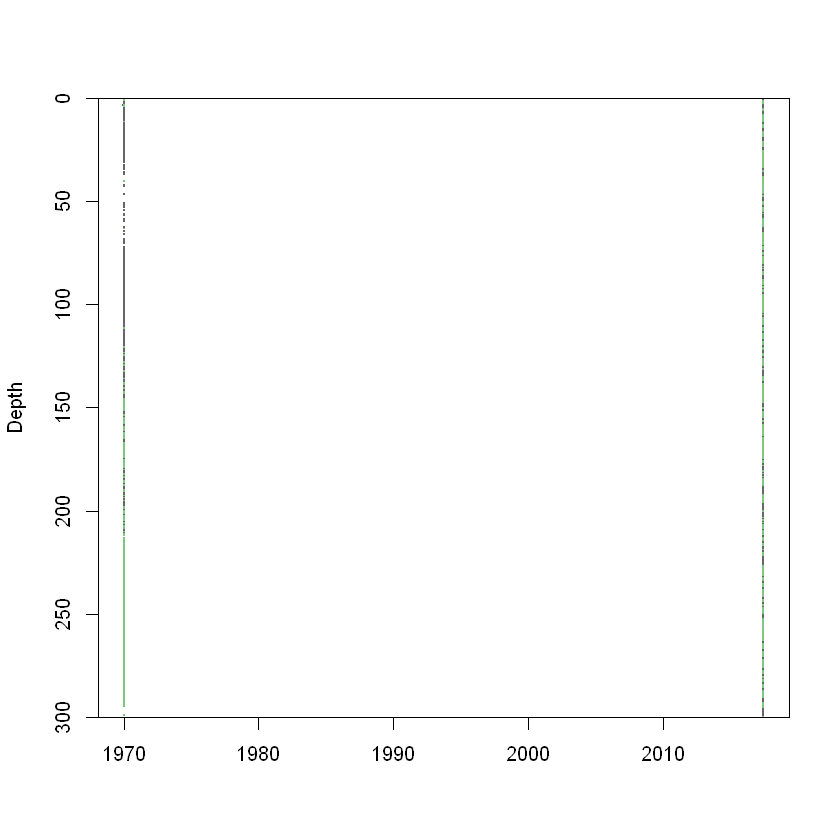

In [23]:
l = seq(1, nrow(data$sensor), length.out = 1e5)
plot(data$sensor$time.real[l], data$sensor$p[l], cex=0.1, pch=20, col=get.qual.pal(3)[data$sensor$direction[l]+2],
     ylim=c(300,0), yaxs='i', ylab='Depth', xlab='')

#points(data$sensor$time[data$sensor$p.FLAG == 3], data$sensor$p[data$sensor$p.FLAG == 3], pch=4, col='red', cex=0.5)

In [ ]:
data$sensor$p[1:20]
data$sensor$time.real[1:20]

In [ ]:
get.mld = function(data, rho = 0.1) {
    
    data$sensor = data$sensor[data$sensor$p > 5 & data$sensor$p < 100,]
    
    ## Smooth Signal
    data$sensor$sigma1 = runmed(data$sensor$sigma1, 5)
    
    mld = data.frame(time = 0, lat = 0, lon = 0, mld = 0, stringsAsFactors = FALSE)
    
    ## Find all the 10meter points on the downcast
    l = which((data$sensor$p - 10)^2 < 0.1 & data$sensor$direction == -1)
    
    ## For each 10m point, take one, remove others close to it (one per cast)
    i = 1
    while (i < length(l)) {
        dt = as.numeric(difftime(data$sensor$time.real[l], data$sensor$time.real[l[i]], units='mins'))
        k = which(dt^2 < 3^2 & dt > 0) # which entries overlap (same cast)?
        
        if(length(k) > 1) {
            data$sensor$sigma1[l[k]] = median(data$sensor$sigma1[l[k]])
            k = k[l[i] != k] # remove l[i] from overlap entries (k)
            l = l[-k]
        }
        i = i + 1
    }
    print(length(l))
    
    ## calcualte mld add to dataframe
    for (i in 1:length(l)) {
        t.10 = data$sensor$time.real[l[i]]
        rho.10 = mean(data$sensor$sigma1[c((l[i]-1):(l[i]+1))], na.rm = TRUE) # rho10 = avergae of 3 points closests to 10db
        
        
        l.time = which(as.numeric(difftime(data$sensor$time.real, t.10, unit='mins'))^2 < 3^2 &
                       data$sensor$direction == -1 & data$sensor$p > 10 &
                       as.numeric(difftime(data$sensor$time.real, t.10, unit='mins')) > 0)
        
        l.mld = min(which(data$sensor$sigma1[l.time] > rho.10 + rho & data$sensor$p[l.time] > 10))
        t.mld = data$sensor$time.real[l.time[l.mld]]
        
        eng = which.min(as.numeric(difftime(data$eng$time.real, t.10, units = 'mins'))^2)
        mld = rbind(mld, c(t.mld, data$eng$lat[eng], data$eng$lon[eng], data$sensor$p[l.mld]))
    }
    
    mld = mld[-1,]
    mld$time = conv.time(mld$time)
    mld
}

In [ ]:
mld = get.mld(data, 0.1)
mld2 = get.mld(data, 0.2)

In [ ]:
#plot(data$sensor$time.real, data$sensor$p, cex=0.1, pch=20, col=get.qual.pal(3)[data$sensor$direction+2],
#     ylim=c(300,0), yaxs='i', ylab='Depth', xlab='')
plot(data$sensor$time.real[c(1, nrow(data$sensor))], data$sensor$p[c(1, nrow(data$sensor))], cex=0.1, pch=20, col='white',
     ylim=c(300,0), yaxs='i', ylab='Depth', xlab='')

points(mld$time, mld$mld, pch=4, col='dark red')
points(mld2$time, mld2$mld, pch=1, col='dark blue', cex=0.3)
#points(data$sensor$time[data$sensor$p.FLAG == 3], data$sensor$p[data$sensor$p.FLAG == 3], pch=4, col='red', cex=0.5)

In [ ]:
plot.map(lon = mld$lon, lat = mld$lat, main = 'SeaSoar MLDs', col = make.div.pal(mld$mld, 100))

In [ ]:
seasoar2 = mld
save(seasoar2, file = 'RStates/SeaSoar2.MLD (0.1).rdata')

In [ ]:
save(data, file='RStates/SeaSoar2.final.rdata')

---
# Review

In [ ]:
plot.mld = function(i, window = 3) {
    l = which(as.numeric(difftime(data$sensor$time.real, mld$time[i], units = 'mins')) < window &
              as.numeric(difftime(data$sensor$time.real, mld$time[i], units = 'mins')) >= -0.5)
    
    plot(data$sensor$sigma1[l], data$sensor$p[l], ylim=c(100,0), xlim=c(1023,1027), yaxs='i',
         pch=20, col='#00000050', cex=1, main=i, ylab='Depth', xlab='Density')
    lines(c(0,10000), rep(mld$mld[i], 2), lty=2, col='red')
    lines(c(0,10000), rep(mld2$mld[i], 2), lty=1, col='red')
    lines(c(0,10000), rep(10, 2), lty=2, col='blue')
}

In [ ]:
par(mfrow=c(2,2))

for(i in 1:nrow(mld)) {
    plot.mld(i)
}